# On Parcels
> An introductory article to Voxels' Parcel Data

- toc: true
- filename: Parcels
- tab: CVMinigames | Parcels
- title: CVMinigames
- template: article
- description: this isnt working
- image: images/company_logo.png
- keywords: thisworks
- badges: true
- comments: true
- categories: [test]
- hide: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## Parcel Data

In [1]:
#hide 
# !pip install matplotlib  
# !pip install requests

&emsp; Voxels provides generic data on ALL their [parcels](https://www.cryptovoxels.com/api/parcels/search.json). The data contains geocoordinates and a bit of meta data which can let us do fun stuff like creating this <a href="https://cvminigames.com/blog/docs/maps/cv_price_map.html"> map</a>. Here is a frequency plot of Islands by parcel size and also a box and whiskers of that same data.

In [149]:
#hide 
import requests
import pandas as pd
import json
url = 'https://www.cryptovoxels.com/api/parcels/search.json'
r = requests.get(url)
data = json.loads(r.text)['parcels'] 
parcels = pd.DataFrame.from_dict(data)
parcels['hasBasement'] = parcels['y1'] < 0
parcels['bordersOcean'] = parcels['distance_to_ocean'] == 0
parcels['bordersCommon'] = parcels['distance_to_closest_common'] == 0
parcels['x'] = (parcels['x1'] - parcels['x2']).abs()
parcels['y'] = (parcels['y2'] - parcels['y1']).abs()
parcels['z'] = (parcels['z1'] - parcels['z2']).abs()
parcels['y'] = parcels.apply(lambda x: x['y'] if x['y'] else x['y1'], axis=1)
parcels['owner'] = parcels.apply(lambda x: x['owner_name'] if x['owner_name'] else x['owner'], axis=1)
parcels['name'] = parcels.apply(lambda x: x['name'] if x['name'] else x['address'], axis=1)
parcels.drop(['x1', 'z1', 'y1', 'y2', 'x2', 'z2', 'hash', 'height', 'geometry', 'owner_name', 'address', 'label', 'distance_to_closest_common', 'distance_to_ocean', 'distance_to_center', 'kind' ], axis=1, inplace=True) 
parcels.head(10)

,id,suburb,island,name,area,owner,hasBasement,bordersOcean,bordersCommon,x,y,z
0,9039,Unknown,Obscurity,2 Esoteric Estates,105,cv_team,False,False,False,15,12,7
1,9038,Unknown,Obscurity,19 Boulevard of Uncertainty,98,0x5a6c1afa7d14fd608af17d7e58e8db52df5d66ea,False,False,False,14,17,7
2,9037,Unknown,Obscurity,2 Peristal Singum Palace,180,0x113d754ff2e6ca9fd6ab51932493e4f9dabdf596,False,False,False,9,10,20
3,9036,Unknown,Obscurity,ExtinctEggs Community Park,400,spacefish.eth,False,False,False,20,8,20
4,9035,Unknown,Obscurity,2 Absent Avenue,180,0x113d754ff2e6ca9fd6ab51932493e4f9dabdf596,False,False,False,15,10,12
5,9034,Unknown,Obscurity,17 Boulevard of Uncertainty,294,0x7e5285f162c662b1b9bd06498f8ea1aa2ca0de4b,False,False,False,14,8,21
6,9033,Unknown,Obscurity,2 Recondite Palace,168,0x113d754ff2e6ca9fd6ab51932493e4f9dabdf596,False,False,False,12,9,14
7,9032,Unknown,Obscurity,PARADISE INFERNO,204,lor-earth.eth,False,False,False,12,10,17
8,9031,Unknown,Obscurity,7 Boulevard of Uncertainty,168,0x7e5285f162c662b1b9bd06498f8ea1aa2ca0de4b,False,False,False,14,17,12
9,8792,Unknown,Obscurity,Obscure Square,703,cv_team,False,False,True,19,10,37


In [150]:
#hide 
rdf = parcels.copy() #parcels[['id', 'name', 'island','suburb','area','height', 'owner_name']].copy()
rdf['vol=xyz'] = rdf['y'] * rdf['area']
rdf['vol=(y+5)*xz'] = (rdf['y'] +5) * rdf['area']
rdf = rdf.sort_values('vol=xyz', ascending=True)
rdf = rdf.reset_index(drop=True)
rdf = rdf.reset_index()
# rdf = rdf[rdf['owner_name'] != 'crvox.eth']
# rdf = rdf[rdf['owner_name'] != 'bnolan']
rdf.head()

,index,id,suburb,island,name,area,owner,hasBasement,bordersOcean,bordersCommon,x,y,z,vol=xyz,vol=(y+5)*xz
0,0,6372,Honolulu,Honolulu,41b Auahi Ave,56,bnolan,False,False,False,7,1,8,56,336
1,1,6304,Igloo,Igloo,2b Graupel Ave,64,0x1fe1ba42a4767ba1807454125a0a00e14744d0bb,False,False,False,8,1,8,64,384
2,2,6438,Pilikai,Pilikai,7b Maia Street,70,Dreuseff,False,False,False,7,1,10,70,420
3,3,6746,Gold,Scarcity,23b Antarcticite Road,104,0x78511cfe4e4a31361aaeece3485a5ddc4d11ce08,False,False,False,13,1,8,104,624
4,4,6305,Igloo,Igloo,13b Laptev Ave,104,sarahq.eth,False,False,False,8,1,13,104,624


C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23487 (\N{CJK UNIFIED IDEOGRAPH-5BBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50872

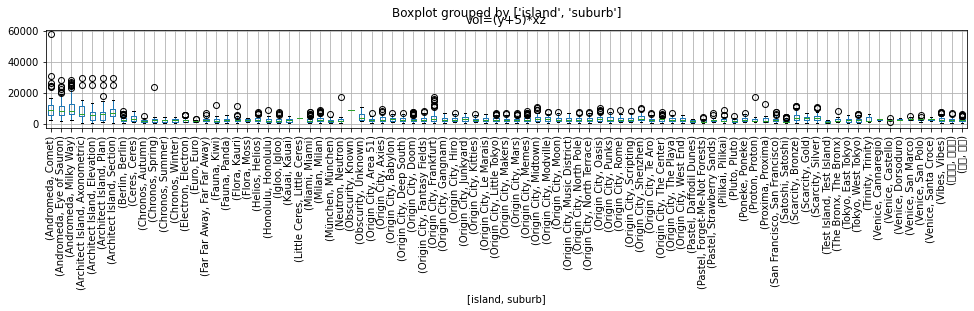

In [151]:
#hide_input 
import matplotlib.pyplot as plt
rdf.boxplot(column=['vol=(y+5)*xz'], by=['island', 'suburb'], rot=90, figsize=(16,4), layout=(2, 1))
plt.show()

In [152]:
#hide_input 
rdf.hist(by=['island'], column = 'vol=(y+5)*xz', figsize=(16,16))
plt.show()

C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23487 (\N{CJK UNIFIED IDEOGRAPH-5BBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\carlos\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50872

In [ ]:
rdf.head()

,index,id,suburb,island,name,area,owner,hasBasement,bordersOcean,bordersCommon,x,y,z,vol=xyz,vol=(y+5)*xz
0,0,7028,Comet,Andromeda,Peacock Gardens,2223,cv_team,True,False,True,39,21,57,46683,57798
1,1,7593,Section,Architect Island,5 Corbusier Ave,792,cv_team,False,False,False,18,32,44,25344,29304
2,2,7595,Plan,Architect Island,3 Wright Street,792,cv_team,False,False,False,44,32,18,25344,29304
3,3,7594,Axonometric,Architect Island,3 Corbusier Ave,792,cv_team,False,False,False,18,32,44,25344,29304
4,4,7592,Elevation,Architect Island,3 Gaudi Terrace,792,cv_team,False,False,False,44,32,18,25344,29304


In [ ]:
# get number of records in parcels
len(parcels)

8553

In [ ]:
%%capture
!pip install pivottablejs

In [ ]:
#hide_input 
# https://github.com/JasonKessler/scattertext
# https://colab.research.google.com/drive/1VIMd9jhpNgB9siYlTSFqjV62mMQQFx4K

from pivottablejs import pivot_ui
from IPython.display import HTML
#if using locally you can just use the following to display the output: pivot_ui(df)
# As we are using colab, we will just download the output - this can then be opened in a new tab in the browser

import IPython

pivot_ui( rdf, outfile_path='../docs/tables/parcelsPivotTable.html')
# IPython.display.HTML(filename='../docs/tables/parcelsPivotTable.html')

from IPython. display import clear_output
clear_output()

## Filtering Parcels

&emsp; Information about a specific parcel is available by adding it's parcel number + .json to the end of the following url: https://www.cryptovoxels.com/api/parcels/ This data can then be filtered en-mass to search for certain properties, or inspected individually.  For example, here is a [map](https://cvminigames.com/blog/docs/maps/cv_book_map.html) of all the guestbooks! The information explored this far can be interactively explored standalone [here](https://cvminigames.com/blog/docs/tables/parcelsPivotTable.html)